In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import sklearn


from torch.utils.tensorboard import SummaryWriter
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import confusion_matrix,accuracy_score

/home/rui/software/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Function

In [2]:
class dataset(Dataset):
    def __init__(self,label,sample):
        self.label=label
        self.sample = sample
    def __getitem__(self, index):
        label = self.label[index]
        smp = self.sample[index]
        return label,smp
    def __len__(self):
        return len(self.sample)

In [3]:
# 初始化网络权重
def init_weights(layer):
    # 如果为卷积层，使用正态分布初始化
    if type(layer) == nn.Conv1d:
        nn.init.normal_(layer.weight, mean=0, std=0.5)
    # 如果为全连接层，权重使用均匀分布初始化，偏置初始化为0.1
    elif type(layer) == nn.Linear:
        nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
        nn.init.constant_(layer.bias, 0.1)

# 数据合并
def get_train(h,y,b,smpNumber):
  train = torch.cat((h,y,b),0)
  train = train.reshape(-1,smpNumber,1,1774)
  return train
# 标签独热编码
# 接受一个一维长N的标签张量，转化为(N,3)的独热编码张量
def one_hot(lable,batch_size):
  lable=lable.reshape(batch_size,1).to(torch.int64)
  
  zero = torch.zeros(batch_size,3)
  onehot = zero.scatter_(1,lable,1)
  return onehot
# 将三类样本的总和还原成三个对应样本的子集,数据类型是numpy数组
def splitTheTrain(train):
  h = train[:,0:264]
  y = train[:,264:704]
  b = train[:,704:784]

  return h,y,b

def splitTheTest(train):
  h = train[:,0:30]
  y = train[:,30:64]
  b = train[:,64:]

  # h = train[:,0:59]
  # y = train[:,59:154]
  # b = train[:,154:177]
  return h,y,b

def tensor_plot(h_t,y_t,b_t):
  h_plt = torch.mean(h_t,dim=0)
  y_plt = torch.mean(y_t,dim=0)
  b_plt = torch.mean(b_t,dim=0)

  plt.figure(figsize=(12,10))
  plt.plot(h_plt.detach().numpy(),label="Healthy")
  plt.plot(b_plt.detach().numpy(),label="Hepatitis C")
  plt.plot(y_plt.detach().numpy(),label="Hepatitis B")
  plt.title("sample-display")
  plt.legend()
  plt.show()

def numpy_plot(h_t,y_t,b_t):
  #h_plt = np.mean(h_t,0)
  #y_plt = np.mean(y_t,0)
  #b_plt = np.mean(b_t,0)
  h_plt = np.mean(h_t,1)
  y_plt = np.mean(y_t,1)
  b_plt = np.mean(b_t,1)
  plt.figure(figsize=(12,10))
  plt.plot(h_plt,label="Healthy")
  plt.plot(b_plt,label="Hepatitis C")
  
  plt.plot(y_plt,label="Hepatitis B")

  
  plt.title("sample-display")
  plt.legend()
  plt.show()

In [4]:
# 这个函数传入三个文件的URL，返回一个对应的dataloader
def getDataLoader(dataType,h_df,y_df,b_df,batchSize):
  if dataType=="train":
    #load the training datafile   
    #change them to the tensor
    h_t = torch.from_numpy(h_df)
    y_t = torch.from_numpy(y_df)
    b_t = torch.from_numpy(b_df)
    print(h_t.shape,y_t.shape,b_t.shape)
    #view
    tensor_plot(h_t,y_t,b_t)
    #generate the lable
    h_train_label = torch.zeros((264,1))
    y_train_label = torch.ones((440,1))
    tmp1 = torch.ones((80,1))
    tmp2 = torch.ones((80,1))
    b_train_label = tmp1.add(tmp2)
    #split the traindata into five subset
    h_train = h_t.reshape(-1,1,1774)
    print("Healthy: ",h_train.shape)
    y_train = y_t.reshape(-1,1,1774)
    print("Hepatitis B: ",y_train.shape)
    b_train = b_t.reshape(-1,1,1774)
    print("Hepatitis C: ",b_train.shape)
    # concat the three class
    train_label = torch.cat((h_train_label,y_train_label,b_train_label),0)
    train_smp = torch.cat((h_train,y_train,b_train),0)
    print("train_label:",train_label.shape)
    print("train_smp:",train_smp.shape)
    train_dataset = dataset(train_label,train_smp)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
    return train_dataloader
  if dataType=="test":
    #change them to the tensor
    h_t = torch.from_numpy(h_df)
    y_t = torch.from_numpy(y_df)
    b_t = torch.from_numpy(b_df)
    print(h_t.shape,y_t.shape,b_t.shape)
    tensor_plot(h_t,y_t,b_t)
    #generate the label
    h_test_label = torch.zeros((30,1))
    y_test_label = torch.ones((34,1))
    tmp1 = torch.ones((31,1))
    tmp2 = torch.ones((31,1))
    b_test_label = tmp1.add(tmp2)
    
    #concat the data
    h_test = h_t.reshape(-1,1,1774)
    y_test = y_t.reshape(-1,1,1774)
    b_test = b_t.reshape(-1,1,1774)
    #
    test_label = torch.cat((h_test_label,y_test_label,b_test_label),0)
    test_smp = torch.cat((h_test,y_test,b_test),0)
    print("test_label:",test_label.shape)
    print("test_smp:",test_smp.shape)
    test_dataset = dataset(test_label,test_smp)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)
    return test_dataloader

### Run CNN

In [6]:
h_train = pd.read_csv('/home/rui/GHIL_with_data/train_h.csv', header= None).values.T
y_train = pd.read_csv('/home/rui/GHIL_with_data/train_y.csv', header= None).values.T
b_train = pd.read_csv('/home/rui/GHIL_with_data/train_b.csv', header= None).values.T
h_test = pd.read_csv('/home/rui/GHIL_with_data/test_h.csv', header= None).values.T
y_test = pd.read_csv('/home/rui/GHIL_with_data/test_y.csv', header= None).values.T
b_test = pd.read_csv('/home/rui/GHIL_with_data/test_b.csv', header= None).values.T
print(
    h_train.shape,
    y_train.shape,
    b_train.shape,
    h_test.shape,
    y_test.shape,
    b_test.shape
)

(1774, 264) (1774, 440) (1774, 80) (1774, 30) (1774, 34) (1774, 31)


In [7]:

ss1 = StandardScaler()

train=np.concatenate((h_train,y_train,b_train),1)
ss1.fit(train)
ss1_train=ss1.transform(train)
ss_h_train,ss_y_train,ss_b_train=splitTheTrain(ss1_train)
ss_h_train=ss_h_train.T
ss_y_train=ss_y_train.T
ss_b_train=ss_b_train.T

test=np.concatenate((h_test,y_test,b_test),1)
ss1.fit(test)
ss1_test=ss1.transform(test)
ss_h_test,ss_y_test,ss_b_test=splitTheTest(ss1_test)
ss_h_test=ss_h_test.T
ss_y_test=ss_y_test.T
ss_b_test=ss_b_test.T

torch.Size([264, 1774]) torch.Size([440, 1774]) torch.Size([80, 1774])


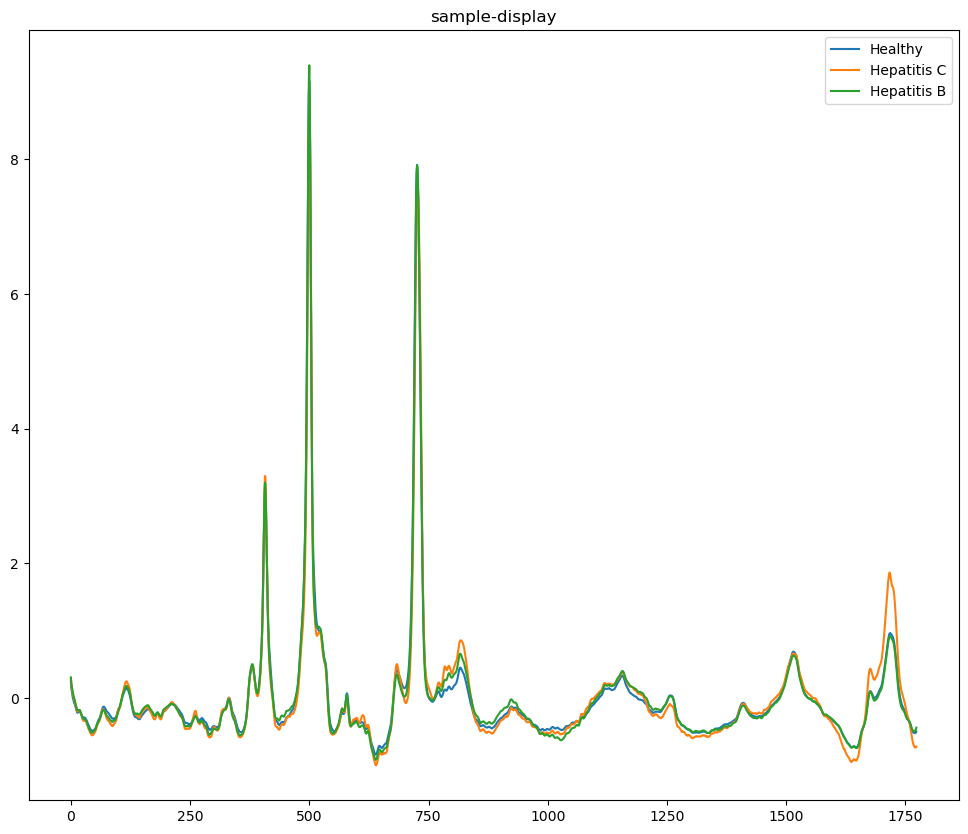

Healthy:  torch.Size([264, 1, 1774])
Hepatitis B:  torch.Size([440, 1, 1774])
Hepatitis C:  torch.Size([80, 1, 1774])
train_label: torch.Size([784, 1])
train_smp: torch.Size([784, 1, 1774])


In [8]:
train_data = getDataLoader("train",
              ss_h_train,
              ss_y_train,
              ss_b_train,784)

torch.Size([30, 1774]) torch.Size([34, 1774]) torch.Size([31, 1774])


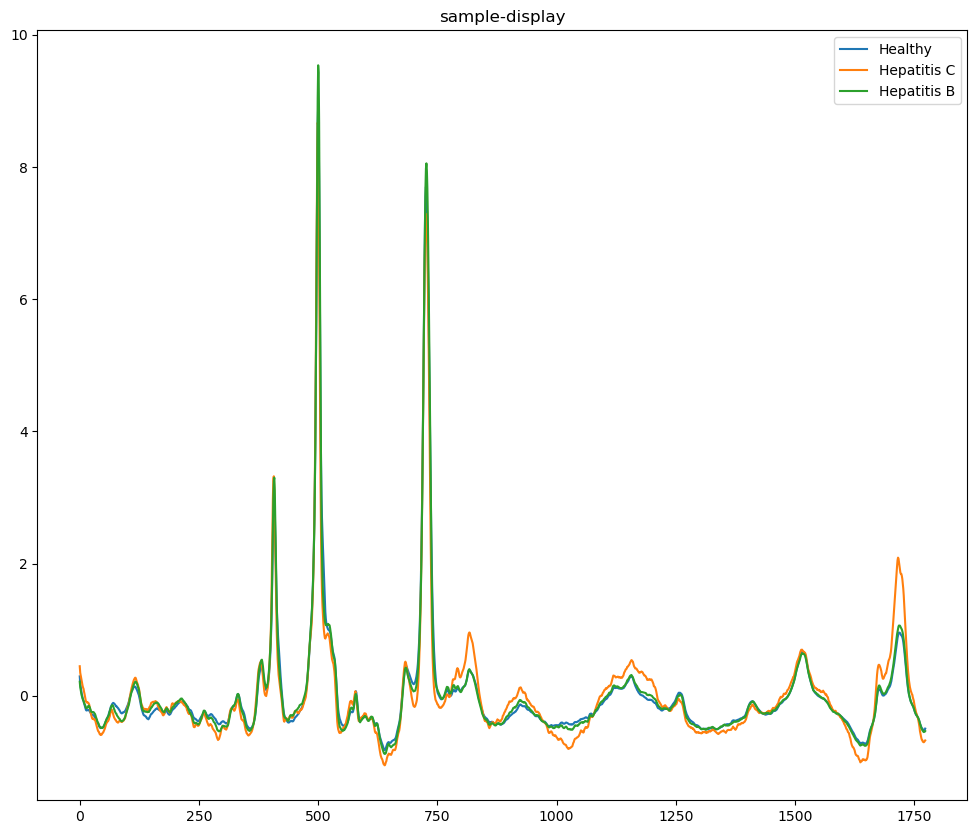

test_label: torch.Size([95, 1])
test_smp: torch.Size([95, 1, 1774])


In [9]:
test_data = getDataLoader("test",
              ss_h_test,
              ss_y_test,
              ss_b_test,95)

In [10]:
cnn_size=5
cnn_step=2
class tests(nn.Module):
    def __init__(self):
        super(tests,self).__init__()
        self.conv1 = nn.Conv1d(1,1,cnn_size,cnn_step)
        self.conv2 = nn.Conv1d(1,1,cnn_size,cnn_step)
        self.pol = nn.MaxPool1d(4, stride=2)

    def forward(self, train):
        x = F.relu(self.conv1(train))
        x = F.relu(self.conv2(x))
        x = self.pol(x)     
        return x.shape
testss = tests()
x = torch.rand(1,1,1774)
sizes=testss(x)[2]
print(sizes)

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv1d(1,1,cnn_size,cnn_step)
        self.conv2 = nn.Conv1d(1,1,cnn_size,cnn_step)
        self.pol = nn.MaxPool1d(4, stride=2)
        self.linear1 = nn.Linear(sizes,128)
        self.linear2 = nn.Linear(128,32)
        self.linear3 = nn.Linear(32,3)



        self.softmax = nn.Softmax(dim=2)
    def forward(self, train):
        x = F.relu(self.conv1(train))
        x = F.relu(self.conv2(x))
        x = self.pol(x)

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        #x = self.softmax(x)
        return x

219


In [24]:
import torch.optim as optim
cnn_module = CNN().double().requires_grad_(requires_grad=True).to("cpu")
criterion = nn.CrossEntropyLoss()
train_loss = []
test_loss = []
train_epochs_loss = []
test_epochs_loss = []

train_acc = []
test_acc = []
train_epochs_acc = []
test_epochs_acc = []
cnn_module.apply(init_weights)

CNN(
  (conv1): Conv1d(1, 1, kernel_size=(5,), stride=(2,))
  (conv2): Conv1d(1, 1, kernel_size=(5,), stride=(2,))
  (pol): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=219, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=3, bias=True)
  (softmax): Softmax(dim=2)
)

In [53]:
cnn_module = CNN().double().requires_grad_(requires_grad=True).to("cpu")
criterion = nn.CrossEntropyLoss()
train_loss = []
test_loss = []
train_epochs_loss = []
test_epochs_loss = []

train_acc = []
test_acc = []
train_epochs_acc = []
test_epochs_acc = []
cnn_module.apply(init_weights)
# optimizer = optim.Adam(cnn_module.parameters(), lr=0.00015)
# optimizer = optim.Adam(cnn_module.parameters(), lr=0.00015)

CNN(
  (conv1): Conv1d(1, 1, kernel_size=(5,), stride=(2,))
  (conv2): Conv1d(1, 1, kernel_size=(5,), stride=(2,))
  (pol): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=219, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=3, bias=True)
  (softmax): Softmax(dim=2)
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Prediction:  tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 0, 2, 1, 0,
        2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2])
Ground Truth:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Confusion Matrix:
 [[26  4  0]
 [ 4 26  4]
 [ 6 16  9]]
Accuracy:  0.6421052631578947


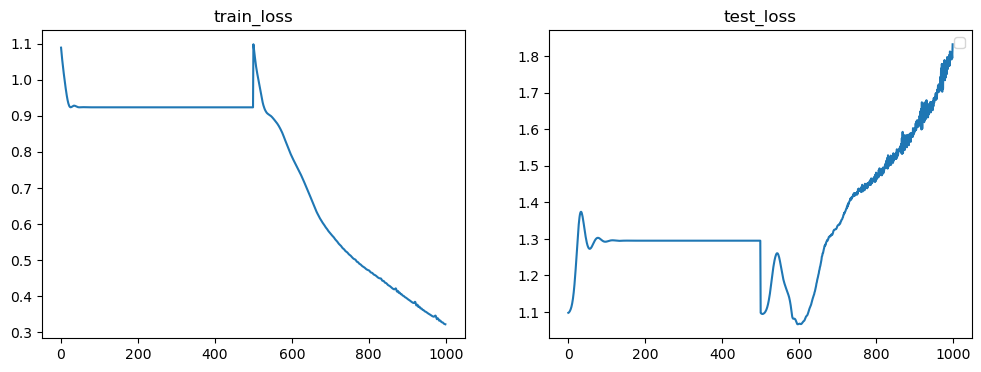

In [55]:
epochs = 500
cnn_module.apply(init_weights)
optimizer = optim.Adam(cnn_module.parameters(), lr=0.0005)
for epoch in range(epochs):
    cnn_module.train()
    train_epoch_loss=[]
    for idx,(y,x) in enumerate(train_data,0):
      optimizer.zero_grad()
      out = cnn_module(x).reshape(-1,3)
      y = y.long()
      y=y.reshape(len(y),)

      loss = criterion(out,y)
      loss.backward()
      optimizer.step()

      train_epoch_loss.append(loss.item())
      train_loss.append(loss.item())
      # print("epoch={}/{},{}/{}of train, loss={}".format(
          # epoch, epochs, idx, len(train_data),loss.item()))
      train_epochs_loss.append(np.average(train_epoch_loss))
  #=====================valid============================
    cnn_module.eval()
    test_epoch_loss = []
    for idx,(y,x) in enumerate(test_data,0):
      outputs = cnn_module(x).reshape(-1,3)
      y = y.long()
      y=y.reshape(len(y),)
      loss = criterion(outputs,y)
      test_epoch_loss.append(loss.item())
      test_loss.append(loss.item())
      #print("epoch={}/{},{}/{}of test, loss={}".format(
          #epoch, epochs, idx, len(cnn_test_dataloader),losss.item()))
    test_epochs_loss.append(np.average(test_epoch_loss))
cnn_module.eval()
pres = []
labels = []
for idx,(y,x) in enumerate(test_data,0):
  outputs = cnn_module(x)
  outputs=outputs.reshape(-1,3)

  pre = torch.argmax(outputs,1)
  pres = pre
  print("Prediction: ",pre)
  y = y.long()
  y=y.reshape(len(y),)
  print("Ground Truth: ",y)
  labels = y
print("Confusion Matrix:\n",confusion_matrix(labels, pres))
print("Accuracy: ",accuracy_score(labels, pres))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(test_loss[:])
plt.title("test_loss")
plt.legend()
plt.show()

In [16]:
pd.DataFrame(train_epochs_loss[1:])

,0
0,1.099275
1,1.098256
2,1.097250
3,1.096233
4,1.095201
...,...
1754,0.200610
1755,0.200271
1756,0.199895
1757,0.199538


In [16]:
train_loss_df = pd.DataFrame(train_loss[:])
train_loss_df.to_csv("./CNN/cnn_train_loss.csv")
train_epochs_loss_df = pd.DataFrame(train_epochs_loss[1:])
train_epochs_loss_df.to_csv("./CNN/cnn_train_epochs_loss.csv")
test_epochs_loss_df = pd.DataFrame(test_epochs_loss[1:])
train_loss_df.to_csv("./cnn_test_epochs_loss.csv")

In [17]:
pres_df = pd.DataFrame(pres)
pres_df.to_csv("./CNN/cnn_pres.csv")
labels_df = pd.DataFrame(labels)
labels_df.to_csv("./CNN/cnn_labels.csv")
pres_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
90,2
91,1
92,1
93,1


In [18]:
mark = []
cnn_module.eval()
for idx,(y,x) in enumerate(test_data,0):
  outputs = cnn_module(x)

  outputs=outputs.reshape(-1,3)
  print(outputs)
  mark = outputs

tensor([[ 5.6303e+00, -2.8298e+00, -1.4028e+00],
        [ 1.0179e+01, -7.0207e+00, -7.9936e-01],
        [ 8.6148e+00, -8.0743e+00,  1.6495e+00],
        [ 5.3007e+00, -7.7645e+00,  4.3595e+00],
        [ 6.0426e+00, -3.9952e+00, -4.4163e-01],
        [ 5.1502e+00, -5.5951e+00,  1.8906e+00],
        [ 7.2765e+00,  2.0520e+00, -8.3322e+00],
        [ 9.4279e+00, -6.9629e+00, -2.9695e-01],
        [ 8.0274e+00, -5.1854e+00, -9.9643e-01],
        [ 1.6340e+01, -1.2675e+01,  8.0871e-04],
        [ 8.0946e+00, -1.9625e+00, -4.5965e+00],
        [ 8.4214e+00, -6.2540e+00, -1.9724e-01],
        [ 1.2327e+01, -1.0318e+01,  8.2987e-01],
        [ 8.7622e+00, -8.0921e+00,  1.5934e+00],
        [ 1.1800e+01, -9.1289e+00,  2.3742e-01],
        [ 9.1952e+00, -6.2709e+00, -6.6600e-01],
        [ 6.1141e+00, -2.4554e+00, -2.3132e+00],
        [ 6.8539e+00, -5.5395e+00,  3.5944e-01],
        [ 5.6949e+00, -2.3333e+00, -2.1835e+00],
        [ 7.1755e+00, -8.0547e-01, -5.0868e+00],
        [ 1.6799e+01

In [55]:
sft = nn.Softmax(dim=1)
x = sft(mark)

In [57]:
mark_df = pd.DataFrame(x.detach().numpy())
mark_df.to_csv("./CNN/cnn_pre_score.csv")